# Глубинное обучение в анализе графовых данных, ПМИ ВШЭ

## Семинар 6

На этом семинаре мы сместим акцент с однородных графов на гетерогенные графы. Гетерогенные графы расширяют традиционные однородные графы, с которыми мы работали, путем включения различных типов узлов и ребер. Эта дополнительная информация позволяет нам расширить модели графовых нейронных сетей, с которыми мы работали ранее. А именно, мы можем применить разнородную передачу сообщений, где теперь существуют разные типы сообщений между разными отношениями типа узла и ребра.

In [3]:
# import torch

# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install deepsnap

### Основы DeepSNAP

[DeepSNAP](https://github.com/snap-stanford/deepsnap) — это библиотека Python, помогающая эффективному глубокому обучению на графах. Особенности DeepSNAP в поддержке гибких манипуляций с графами, стандартного конвейера, гетерогенных графов и простого API.

1. DeepSNAP легко использовать для сложных манипуляций с графами, таких как вычисление признаков, предварительное обучение, извлечение подграфов и т. д. во время или перед обучением.
2. В большинстве фреймворков стандартные конвейеры для задач на уровне узла, ребра, ссылки, графа при индуктивных или трансдуктивных настройках оставляются на усмотрение пользователя. На практике существуют дополнительные варианты проектирования (например, как разделить набор данных для прогнозирования ссылок).
3. Многие графы реального мира являются гетерогенными графами. Но в пакетах отсутствует поддержка гетерогенных графов, включая хранение данных и гибкую передачу сообщений. DeepSNAP предоставляет эффективный и гибкий гетерогенный граф, который поддерживает гетерогенность как узлов, так и ребер.

## 1) Гетерогенный граф DeepSNAP

Сначала мы рассмотрим, как преобразовать граф NetworkX в формат, поддерживаемый DeepSNAP.

В DeepSNAP у нас есть три уровня атрибутов. У нас могут быть атрибуты **уровня узла**, включая `node_feature` и `node_label`. Два других уровня атрибутов — это атрибуты графа и ребра. Использование аналогично уровню узла, за исключением того, что функция становится «edge_feature» или «graph_feature», а метка становится «edge_label» или «graph_label» и т. д.

DeepSNAP расширяет свое традиционное графическое представление, включая разнородные графы, включая следующие функции свойств графа:
* `node_feature`: признаки каждой вершины (`torch.tensor`)
* `edge_feature`: признаки каждого ребра (`torch.tensor`)
* `node_label`: метка каждой вершины (`int`)
* `node_type`: Тип вершины (`string`)
* `edge_type`: Тип ребра (`string`)

где ключевыми **новыми** признаки, которые мы добавляем, являются `node_type` и `edge_type`, которые позволяют нам выполнять гетерогенную передачу сообщений.

Для этого первого вопроса мы будем работать со знакомым [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html). Для начала, поскольку каждый узел в граф принадлежит к одному из двух клубов (club "Mr. Hi" или club "Officer"), мы будем рассматривать клуб как `node_type`.

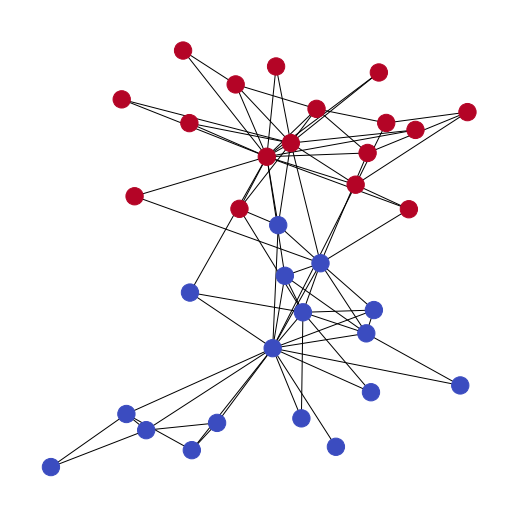

In [1]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy
from pylab import show


G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        community_map[node[0]] = 0
    else:
        community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### Назначение типа узла и признаков узла

Используя словарь `community_map` и граф `G`, добавим атрибуты узла `node_type` и `node_label` к графу G. А именно, для `node_type` назначим узлы в клубе "Mr. Hi" к типу узла ` n0` и узлы в клубе "Officer" узел типа `n1`.

Затем для `node_label` назначим узлам в клубе "Mr. Hi" `node_label` `0`, а узлам в клубе "Officer" `node_label` из `1`.

Наконец, назначим каждому узлу *тензорный* вектор признаков $[1, 1, 1, 1, 1]$.

In [2]:
import torch


def assign_node_types(G, community_map):
    tmp_dic = {0: 'n0', 1: 'n1'}
    node_type = {k: tmp_dic[v] for k, v in community_map.items()}
    nx.set_node_attributes(G, node_type, "node_type")


def assign_node_labels(G, community_map):
    nx.set_node_attributes(G, community_map, "node_label")


def assign_node_features(G):
    nx.set_node_attributes(G, [1., 1., 1., 1., 1.], "node_feature")


assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)
node_id = 20
print(f"Node {node_id} has properties:", G.nodes(data=True)[node_id])

Node 20 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}


### Назначение типов ребер

Далее мы назначим три разных `edge_types`:
* Ребра в клубе "Mr. Hi": `e0`
* Края в клубе "Officer": `e1`
* Ребра между двумя клубами: `e2`

In [3]:
def assign_edge_types(G, community_map):
    tmp_dict = {0: 'e0', 2:'e1', 1:'e2'}
    edge_type = {}
    for edge in G.edges():
        edge_type[edge] = tmp_dict[community_map[edge[0]] + community_map[edge[1]]]
    nx.classes.function.set_edge_attributes(G,edge_type, 'edge_type')



assign_edge_types(G, community_map)
edge_idx = 15
n1 = 0
n2 = 31
edge = list(G.edges(data=True))[edge_idx]
print(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print(f"Node {n1} has properties:", G.nodes(data=True)[n1])
print(f"Node {n2} has properties:", G.nodes(data=True)[n2])

Edge (0, 31) has properties: {'weight': 2, 'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}


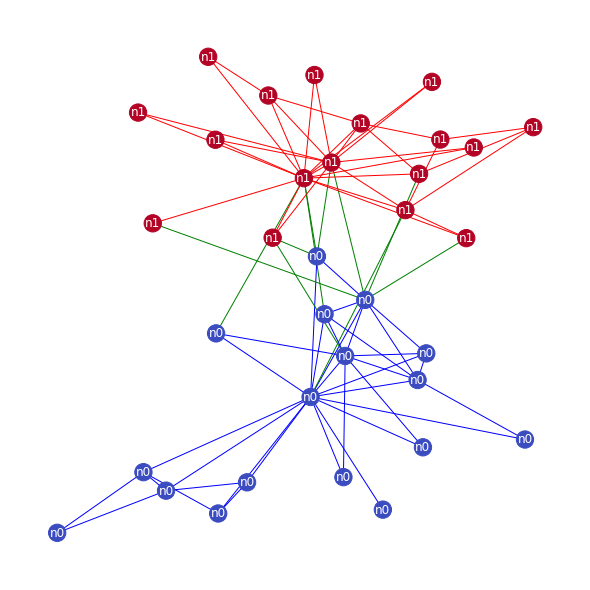

In [4]:
edge_color = {}
for edge in G.edges():
    n1, n2 = edge
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
        edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
        edge_color[edge] = 'red'
    else:
        edge_color[edge] = 'green'

G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G, 'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color,
        edge_color=colors, labels=labels, font_color='white')
show()

где мы различаем ребра внутри каждого клуба (2 типа) и ребра между двумя клубами (1 тип). Различные типы узлов и ребер визуализируются разными цветами. Объект NetworkX `G` далее может быть напрямую преобразован в `deepsnap.hetero_graph.HeteroGraph`.

In [5]:
from deepsnap.hetero_graph import HeteroGraph

hete = HeteroGraph(G_orig)

In [6]:
def get_nodes_per_type(hete):
    num_nodes_n0 = len(hete.node_type['n0'])
    num_nodes_n1 = len(hete.node_type['n1'])

    return num_nodes_n0, num_nodes_n1


num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node type n0 has {} nodes".format(num_nodes_n0))
print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


### Типы сообщений. Сколько ребер относится к каждому типу сообщений

При работе с разнородными графами, как мы обсуждали ранее, мы теперь работаем с разнородными типами сообщений (т. е. с разными типами сообщений для разных комбинаций `node_type` и `edge_type`). Например, ребро типа `e0`, соединяющее два узла в клубе "Mr. HI", будет иметь тип сообщения (`n0`, `e0`, `n0`).

In [7]:
def get_num_message_edges(hete):
    message_type_edges = []

    for k, v in hete.edge_type.items():
        message_type_edges.append((k, len(v)))


    return message_type_edges


message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
    print("Message type {} has {} edges".format(message_type, num_edges))

Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


### Разделение набора данных. Сколько узлов в каждом разделении набора данных

В DeepSNAP встроены методы создания и разделения наборов данных для разнородных графов. Здесь мы создадим наборы данных для обучения, валидации и тестирования для задачи прогнозирования узлов и проверим полученные подграфы

In [8]:
from deepsnap.dataset import GraphDataset


def compute_dataset_split_counts(datasets):
    data_set_splits = {}

    for k, v in datasets.items():
        data_set_splits[k] = v[0].node_label_index['n0'].shape[0] + \
            v[0].node_label_index['n1'].shape[0]

    return data_set_splits


dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train,
            'val': dataset_val, 'test': dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
    print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


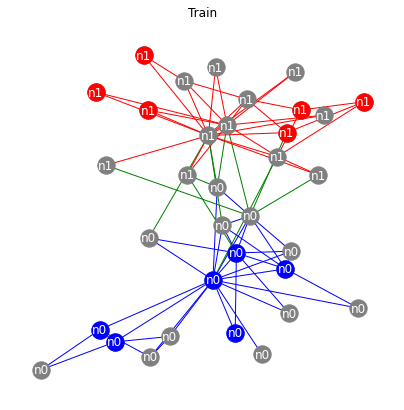

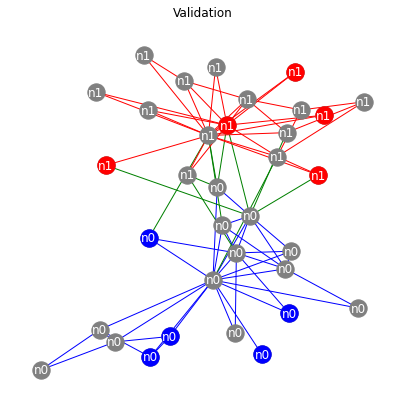

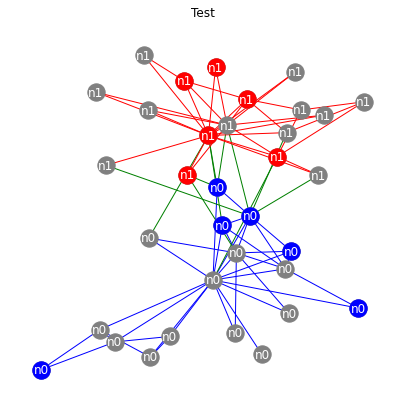

In [9]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hete._convert_to_graph_index(
        dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hete._convert_to_graph_index(
        dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i])
    nx.draw(G_orig, pos=pos, node_color="grey",
            edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

## 2) Прогнозирование свойств узла гетерогенного графа

Теперь мы будем использовать PyTorch Geometric и DeepSNAP для реализации модели GNN для прогнозирования свойств узлов гетерогенного графа (классификация узлов). Мы будем опираться на наше понимание гетерогенных графов из лекции и предыдущей работы по реализации слоев GNN с использованием PyG

Сначала давайте взглянем на общую структуру гетерогенного слоя GNN на примере:

Предположим, у нас есть граф $G$, который содержит два типа узлов $a$ и $b$ и три типа сообщений $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$. и $m_3=(a, r_3, b)$. Примечание: во время передачи сообщения мы рассматриваем каждое сообщение как (src, ratio, dst), где сообщения «перетекают» из типов узлов src в dst. Например, при передаче сообщения обновление типа узла $b$ зависит от двух разных типов сообщений $m_2$ и $m_3$.

При применении передачи сообщений в разнородных графах мы отдельно применяем передачу сообщений для каждого типа сообщений. Следовательно, для графа $G$ гетерогенный уровень GNN содержит три отдельных уровня гетерогенной передачи сообщений, где каждый уровень «HeteroGNNConv» выполняет передачу и агрегацию сообщений в отношении *только одного типа сообщений*. Поскольку тип сообщения рассматривается как (src, ratio, dst), а сообщения «перетекают» из src в dst, каждый уровень `HeteroGNNConv` вычисляет эмбединги только для узлов *dst* данного типа сообщения. Например, слой `HeteroGNNConv` для типа сообщения $m_2$ выводит обновленные представления *только* для узлов с типом b.

---

Обзор гетерогенного слоя, который мы создадим, показан ниже:

<br/>
<center>
<img src="https://drive.google.com/uc?export=view&id=1mkp4OeRrvC4iNFTXSywrmI6Pfl5J__gA"/>
<center>
<br/>

где выделим следующие обозначения:

- $H_a^{(l)[m_1]}$ — промежуточная матрица эмбедингов узлов для типа узла $a$, сгенерированная $l$-м слоем `HeteroGNNConv` для типа сообщения $m_1$.
- $H_a^{(l)}$ — матрица с текущими эмбедингами для узлов типа $a$ после $l$-го слоя нашей модели Heterogeneous GNN. Обратите внимание, что эти эмбединги могут основываться на одном или нескольких эмбедингах промежуточного слоя `HeteroGNNConv` (т. е. $H_b^{(l)}$ объединяет $H_b^{(l)[m_2]}$ и $H_b^{(l)[m_3 ]}$).

Поскольку каждый `HeteroGNNConv` применяется только к одному типу сообщений, мы дополнительно определяем уровень гетерогенный GNN Wrapper (HeteroGNNWrapperConv). Этот wrapper управляет и объединяет выходные данные каждого слоя `HeteroGNNConv`, чтобы генерировать полные обновленные эмбединги вершин для каждого типа вершин в слое $l$ нашей модели. В частности, слой $l^{th}$ `HeteroGNNWrapperConv` принимает в качестве входных данных эмбединги узлов, вычисленные для каждого типа сообщения и типа узла (например, $H_b^{(l)[m_2]}$ и $H_b^{(l )[m_3]}$) и объединяет типы сообщений с одним и тем же типом узла $dst$. Результирующий вывод слоя $l^{th}$ `HeteroGNNWrapperConv` представляет собой обновленную матрицу эмбедингов $H_i^{(l)}$ для каждого типа узла i.

Для вычисления эмбедингов узлов $H_b^{(l)}$ wrapper-слой объединяет выходные эмбединги из слоев `HeteroGNNConv`, связанных с типами сообщений $m_2$ и $m_3$ (т. е. $H_b^{( l)[m_2]}$ и $H_b^{(l)[m_3]}$).

---

С помощью модуля `HeteroGNNWrapperConv` мы теперь можем нарисовать «упрощенную» гетерогенную структуру слоев следующим образом:


<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
<center>
<br/>

---

Может быть полезно дополнительно прочитать введение PyG в представление гетерогенных графов и построение гетерогенных моделей GNN: https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html

In [10]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

## Реализация `HeteroGNNConv`

Слой HeteroGNNConv эквивалентен однородным слоям GNN, но теперь применяются к отдельному разнородному типу сообщения. Более того, наш гетерогенный слой GNN основан непосредственно на модели передачи сообщений **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

Начнем с определения слоя HeteroGNNConv относительно типа сообщения $m$:

\begin{equation}
m =(s, r, d)
\end{equation}

где каждый тип сообщения представляет собой кортеж, содержащий три элемента: $s$ — тип исходной вершины, $r$ — тип ребра (отношения) и $d$ — тип вершины назначения.

Правило обновления передачи сообщений, которое мы реализуем, очень похоже на правило GraphSAGE, за исключением того, что теперь нам нужно включить типы узлов и тип отношения ребер. Правило обновления для типа сообщения $m$ описано ниже:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1 )}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

где мы вычисляем $h_v^{(l)[m]}$, эмибединг узла для узла $v$ после слоя `HeteroGNNConv` $l$ с учетом типа сообщения $m$. Далее имеем:
- $W_s^{(l)[m]}$ - матрица линейного преобразования сообщений соседних исходных узлов типа $s$ по типу сообщения $m$.
- $W_d^{(l)[m]}$ - матрица линейного преобразования для сообщения от самой вершины $v$ типа $d$.
- $W^{(l)[m]}$ - матрица линейного преобразования для конкатенированных сообщений от соседних узлов и центрального узла.
- $h_u^{(l-1)}$ - скрытое представление эмбедингов для узла $u$ после $(l-1)$-го слоя `HeteroGNNWrapperConv`. Обратите внимание, что это внедрение не связано с конкретным типом сообщения (см. диаграммы слоев выше).
- $N_{m}(v)$ - множество соседних исходных узлов $s$ для узла v, которое мы вкладываем по типу сообщения $m = (s, r, d)$.

Каждая весовая матрица связана с определенным типом сообщения $[m]$, и, кроме того, весовые матрицы, применяемые к сообщениям узла, различаются по типу узла (т. е. $W_s$ и $W_d$).

Наконец, для простоты мы используем средние агрегации для $AGG$, где:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u \in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [11]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)
        self.lin_update = nn.Linear(out_channels*2, out_channels)


    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None,
        res_n_id=None,
    ):
        return self.propagate(edge_index, node_feature_dst=node_feature_dst, node_feature_src=node_feature_src, size=size, res_n_id=res_n_id)


    def message_and_aggregate(self, edge_index, node_feature_src):
        out = matmul(edge_index, node_feature_src, reduce=self.aggr)

        return out

    def update(self, aggr_out, node_feature_dst, res_n_id):
        aggr_out = torch.cat(
            (self.lin_src(aggr_out), self.lin_dst(node_feature_dst)), dim=-1)
        aggr_out = self.lin_update(aggr_out)

        return aggr_out

## Гетерогенный  GNN Wrapper слой

После реализации слоя `HeteroGNNConv` для каждого типа сообщений нам необходимо управлять и агрегировать результирующие эмбединги узлов (относительно каждого типа сообщений). Здесь мы реализуем два типа агрегации на уровне типов сообщений.

Первый — это просто среднее агрегирование по типам сообщений:

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

где узел $v$ имеет тип узла $d$, и мы суммируем типы сообщений $M$, которые имеют тип узла назначения $d$. Из нашего исходного примера для узла v типа $b$ мы объединяем эмбединги `HeteroGNNConv` v для типов сообщений $m_2$ и $m_3$ (т. е. $h_v^{(l)[m_2]}$ и $h_v^{(l)[m_3]}$).

Второй метод, который мы реализуем, — это внимание на семантическом уровне, представленное в **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)). Вместо прямого усреднения результатов агрегирования типов сообщений мы используем внимание, чтобы узнать, какой результат типа сообщения более важен, а затем агрегируем по всем типам сообщений. Ниже приведены уравнения для семантического уровня внимания:

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l) } \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

где $m$ — тип сообщения, а $d$ — тип узла назначения для этого сообщения ($m = (s, r, d)$). Кроме того, $V_{d}$ относится к набору узлов v с типом $d$. Наконец, ненормализованный вес внимания $e_m$ — это коэффициент масштабирования, вычисляемый для каждого типа сообщения $m$.

Затем мы можем вычислить нормализованные веса внимания и обновить $h_v^{(l)}$:

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation},

здесь $M$ — это количество типов сообщений, связанных с типом узла назначения $d$.


In [12]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
            self.attn_proj = nn.Sequential(
                nn.Linear(args['hidden_size'], args['attn_size'], bias=True),
                nn.Tanh(),
                nn.Linear(args['attn_size'], 1, bias=False)
            )

    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):
        if self.aggr == "mean":
            x = torch.stack(xs)
            out = torch.mean(x, dim=0)
            return out

        elif self.aggr == "attn":
            N = xs[0].shape[0]  # Number of nodes for that node type
            M = len(xs)  # Number of message types for that node type

            x = torch.cat(xs, dim=0).view(M, N, -1)  # M * N * D
            z = self.attn_proj(x).view(M, N)  # M * N * 1
            z = z.mean(1)  # M * 1
            alpha = torch.softmax(z, dim=0)  # M * 1

            # Store the attention result to self.alpha as np array
            self.alpha = alpha.view(-1).data.cpu().numpy()

            alpha = alpha.view(M, 1, 1)
            x = x * alpha
            return x.sum(dim=0)

Теперь соберем все вместе и инициализируем гетерогенные слои GNN. В отличие от случая однородного графа, гетерогенные графы могут быть немного более сложными.

В общем, нам нужно создать словарь слоев HeteroGNNConv, где ключами являются типы сообщений.

* Для получения всех типов сообщений полезен `deepsnap.hetero_graph.HeteroGraph.message_types`.
* Если мы инициализируем первые свёрнутые слои, нам нужно получить размер объекта для каждого типа узла. Использование `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` вернет измерение функции узла `node_type`. В этой функции мы установим для каждого `HeteroGNNConv` `out_channels` значение `hidden_size`.
* Если мы не инициализируем первые свёрнутые слои, все типы узлов будут иметь небольшой размер эмбединга `hidden_size`, и мы по-прежнему устанавливаем `HeteroGNNConv` `out_channels` равным `hidden_size` для простоты.

In [13]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}
    for k in hetero_graph.message_types:
        if first_layer:
            src, dst = k[0], k[2]
            src_size, dst_size = hetero_graph.num_node_features(
                src), hetero_graph.num_node_features(dst)
            convs[k] = conv(src_size, dst_size, hidden_size)
        else:
            convs[k] = conv(hidden_size, hidden_size, hidden_size)

    return convs

## HeteroGNN

Теперь мы создадим простую модель HeteroGNN, которая содержит только два слоя HeteroGNNWrapperConv.

Для forward функции в HeteroGNN модель будет работать следующим образом:

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self .relus2} \rightarrow \text{self.post_mps}$

In [14]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        # 1. For self.convs1 and self.convs2, call generate_convs at first and then
        # pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        # 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        # `deepsnap.hetero_graph.HeteroGraph.node_types` will be helpful.
        # 3. For self.post_mps, each value in the ModuleDict is a linear layer
        # where the `out_features` is the number of classes for that node type.

        convs1 = generate_convs(
            hetero_graph, HeteroGNNConv, args['hidden_size'], True)
        convs2 = generate_convs(
            hetero_graph, HeteroGNNConv, args['hidden_size'], False)
        self.convs1 = HeteroGNNWrapperConv(convs1, args, self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, args, self.aggr)
        for k in hetero_graph.node_types:
            self.bns1[k] = nn.BatchNorm1d(args['hidden_size'], eps=1.0)
            self.relus1[k] = nn.LeakyReLU()
            self.bns2[k] = nn.BatchNorm1d(args['hidden_size'], eps=1.0)
            self.relus2[k] = nn.LeakyReLU()
            self.post_mps[k] = nn.Linear(
                args['hidden_size'], hetero_graph.num_node_labels(k))

    def forward(self, node_feature, edge_index):
        # `node_feature` is a dictionary of tensors where keys are node types and values are
        # corresponding feature tensors. The `edge_index` is a dictionary of
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).

        x = node_feature

        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)
        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)
        x = forward_op(x, self.relus2)
        x = forward_op(x, self.post_mps)

        return x

    def loss(self, preds, y, indices):

        loss = 0
        loss_func = F.cross_entropy

        # Loss need to be computed with respect to the given index
        for node_type in preds:
            indx = indices[node_type]
            loss += loss_func(preds[node_type][indx], y[node_type][indx])

        return loss

In [15]:
import pandas as pd


def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = model.loss(preds, hetero_graph.node_label, train_idx)

    loss.backward()
    optimizer.step()
    return loss.item()


def test(model, graph, indices, best_model=None, best_val=0, save_preds=False, agg_type=None):
    model.eval()
    accs = []
    for i, index in enumerate(indices):
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1

        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))

        # Only save the test set predictions and labels!
        if save_preds and i == 2:
            print(
                "Saving Heterogeneous Node Prediction Model Predictions with Agg:", agg_type)
            print()

            data = {}
            data['pred'] = pred_np
            data['label'] = label_np

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv('ACM-Node-' + agg_type + 'Agg.csv', sep=',', index=False)

    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [16]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

## Набор данных и предварительная обработка

Далее мы загрузим данные и создадим тензор (без графа NetworkX) `deepsnap.hetero_graph.HeteroGraph`.

Мы будем использовать набор данных «ACM (3025)» в нашей задаче прогнозирования свойств вершин, которая предлагается в **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293) ), а наш набор данных извлечен из [DGL](https://www.dgl.ai/) [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

Исходный набор данных ACM имеет три типа узлов и два типа ребер (отношений). Для простоты мы упростим гетерогенный граф до одного типа узлов и двух типов ребер (показано ниже). Это означает, что в нашем гетерогенном графе у нас есть один тип узла (статья) и два типа сообщений (статья, автор, статья) и (статья, тема, статья).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>
</br>

In [17]:
print("Device: {}".format(args['device']))

# Load the data
data = torch.load("data/acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(
    f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(
        args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(
        args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(
        hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cpu
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991]),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022]),
             size=(3025, 3025), nnz=2207736, density=24.13%)


## Training the Mean Aggregation

In [24]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(
    model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(
        model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [
                       train_idx, val_idx, test_idx], save_preds=True, agg_type="Mean")
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.10028, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 2: loss 1.0907, train micro 55.5%, train macro 47.03%, valid micro 41.0%, valid macro 30.15%, test micro 39.06%, test macro 28.29%
Epoch 3: loss 1.05918, train micro 86.83%, train macro 86.52%, valid micro 84.67%, valid macro 84.39%, test micro 66.59%, test macro 64.19%
Epoch 4: loss 0.99465, train micro 71.17%, train macro 64.41%, valid micro 69.67%, valid macro 62.05%, test micro 66.12%, test macro 56.44%
Epoch 5: loss 0.884, train micro 67.83%, train macro 58.01%, valid micro 66.33%, valid macro 55.22%, test micro 65.55%, test macro 54.63%
Epoch 6: loss 0.72636, train micro 67.5%, train macro 57.32%, valid micro 66.33%, valid macro 55.22%, test micro 65.6%, test macro 54.55%
Epoch 7: loss 0.54814, train micro 67.67%, train macro 57.7%, valid micro 66.33%, valid macro 55.64%, test micro 65.55%, test macro 54.49%
Epoch 8: loss 0.39252, train 

## Training the Attention Aggregation

In [25]:
best_model = None
best_val = 0

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Attention")
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.10036, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 2: loss 1.09084, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 3: loss 1.0612, train micro 51.17%, train macro 42.48%, valid micro 38.67%, valid macro 26.56%, test micro 41.27%, test macro 28.22%
Epoch 4: loss 1.00156, train micro 65.33%, train macro 54.49%, valid micro 64.33%, valid macro 53.84%, test micro 62.02%, test macro 52.07%
Epoch 5: loss 0.899, train micro 66.5%, train macro 55.45%, valid micro 66.0%, valid macro 55.07%, test micro 65.08%, test macro 54.39%
Epoch 6: loss 0.75026, train micro 67.67%, train macro 57.78%, valid micro 66.67%, valid macro 55.96%, test micro 65.41%, test macro 54.55%
Epoch 7: loss 0.5755, train micro 69.83%, train macro 61.97%, valid micro 67.33%, valid macro 57.39%, test micro 65.51%, test macro 54.62%
Epoch 8: loss 0.4131, trai

## Внимание для каждого типа сообщения

Посредством внимания на уровне типа сообщения мы можем узнать, какой тип сообщения более важен для какого слоя.

Здесь мы распечатаем и покажем, сколько внимания каждый слой уделяет каждому типу сообщения.

In [26]:
if model.convs1.alpha is not None and model.convs2.alpha is not None:
    for idx, message_type in model.convs1.mapping.items():
        print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
    for idx, message_type in model.convs2.mapping.items():
        print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")

Layer 1 has attention 0.06148515269160271 on message type ('paper', 'author', 'paper')
Layer 1 has attention 0.9385148286819458 on message type ('paper', 'subject', 'paper')
Layer 2 has attention 0.7942582964897156 on message type ('paper', 'author', 'paper')
Layer 2 has attention 0.205741748213768 on message type ('paper', 'subject', 'paper')
